In [1]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense,Dropout,Bidirectional,Conv1D
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import re
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
# Load and preprocess the dataset
df = pd.read_csv('/content/IMDB Dataset.csv' , encoding='utf-8')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
x = df['review']
y = df['sentiment']

In [5]:
def preprocess_text(text):
    text = re.sub(r'<[^>]+>', ' ', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    stemmed_tokens = [PorterStemmer().stem(token) for token in filtered_tokens]
    preprocessed_text = ' '.join(stemmed_tokens)
    return preprocessed_text.lower()

x = [preprocess_text(text) for text in x]
preprocessed_df = pd.DataFrame({"review": x, "sentiment": y})
preprocessed_df.to_csv("preprocessed_data.csv", index=False)

In [6]:
train_texts, test_texts, train_labels, test_labels = train_test_split(x, y, test_size=0.05, random_state=42)

num_words=10000
maxlen=500
label_encoder = LabelEncoder()


train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_texts)


train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)


train_data = pad_sequences(train_sequences, maxlen=maxlen)
test_data = pad_sequences(test_sequences, maxlen=maxlen)



In [ ]:
import tensorflow as tf
from keras.layers import Input, Attention, Concatenate,MaxPooling1D,Flatten
from keras.models import Model

input_sequence = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=num_words, output_dim=maxlen)(input_sequence)
conv_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
pooling_layer = MaxPooling1D(pool_size=4)(conv_layer)
lstm_layer = LSTM(64)(pooling_layer)
flatten_layer = Flatten()(pooling_layer)
merged_layer = Concatenate()([lstm_layer, flatten_layer])
output_layer = Dense(1, activation='sigmoid')(merged_layer)

model = Model(inputs=input_sequence, outputs=output_layer)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(train_data, train_labels, batch_size=128, epochs=5, validation_split=0.2)

loss, accuracy = model.evaluate(test_data, test_labels)
print(f'Test accuracy: {accuracy}')

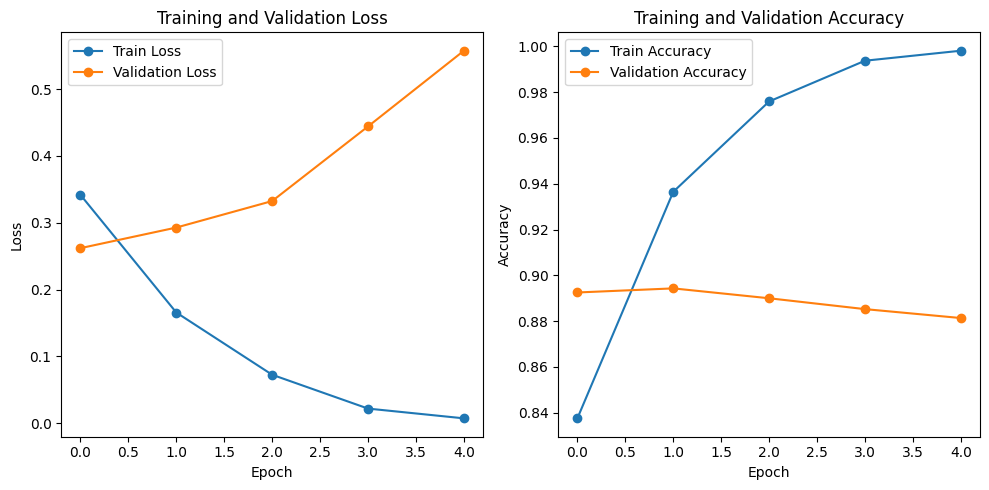

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy', marker='o')
plt.plot(val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
model.save_weights('model_weights.h5')

**Inference**

In [8]:
import tensorflow as tf
from keras.layers import Input, Attention, Concatenate,MaxPooling1D,Flatten
from keras.models import Model

# Rebuild the model architecture
input_sequence = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=num_words, output_dim=maxlen)(input_sequence)
conv_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
pooling_layer = MaxPooling1D(pool_size=4)(conv_layer)
lstm_layer = LSTM(64)(pooling_layer)
flatten_layer = Flatten()(pooling_layer)
merged_layer = Concatenate()([lstm_layer, flatten_layer])
output_layer = Dense(1, activation='sigmoid')(merged_layer)

model1 = Model(inputs=input_sequence, outputs=output_layer)

# Load the saved weights
model1.load_weights('model_weights.h5')

In [9]:
predictions = model1.predict(test_data)

79/79 [==============================] - 10s 6ms/step


In [10]:
predictions

array([[8.0257609e-02],
       [2.1696019e-01],
       [9.9982846e-01],
       ...,
       [3.6047664e-04],
       [9.9777633e-01],
       [4.4875541e-01]], dtype=float32)

In [11]:
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

If number is less than 0.5, it represents 0 and 0 represents negative sentiment. If number is greater than 0.5, it represents 1 and 1 represents positive sentiment.

In [12]:
binary_predictions

array([[0],
       [0],
       [1],
       ...,
       [0],
       [1],
       [0]])

In [13]:
prediction = label_encoder.inverse_transform(binary_predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
prediction

array(['negative', 'negative', 'positive', ..., 'negative', 'positive',
       'negative'], dtype=object)

Enter Your Review

In [45]:
input_string = input("Enter a sentence: ")
print(input_string)

Enter a sentence: I like it
I like it


In [46]:
input_string = preprocess_text(input_string)
input_string =tokenizer.texts_to_sequences([train_texts])
input_string =pad_sequences(input_string, maxlen=maxlen)
predictions = model1.predict(input_string)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)
prediction = label_encoder.inverse_transform(binary_predictions)
print(prediction)

1/1 [==============================] - 0s 22ms/step
['positive']


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [43]:
print(len(prediction))
prediction

1


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['positive'], dtype=object)